In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import load_yaml_model
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gempath = '../../resources/human-GEM/v1.11.0/model/Human-GEM.yml'
gem = load_yaml_model(gempath)

Warning: the code below is useless because the HMDB IDs are not compatible between data sets
Map HMDB IDs to Human-GEM metabolite IDs (`rid`s, i.e replacement IDs)

In [3]:
gempath_xlsx = '../../resources/human-GEM/from-Busra/model/Human-GEM.xlsx'
gem_mets = pd.read_excel(gempath_xlsx, "METS")
s = gem_mets.MIRIAM.apply(lambda ids: re.sub('^.*hmdb/(HMDB[0-9]*).*$', '\\1', ids))
gem_mets['HMDB'] = s.apply(lambda s: None if not re.match('^HMDB', s) else s)
gem_mets = gem_mets.dropna(subset='HMDB')
hmdb2rid = gem_mets.groupby('HMDB').apply(lambda x: x['REPLACEMENT ID'].to_list())
hmdb2rid

HMDB
HMDB0000036               [MAM02963c, MAM02963x, MAM02963e]
HMDB00002                            [MAM00248c, MAM00248e]
HMDB00005                 [MAM00671c, MAM00671m, MAM00671e]
HMDB00008                            [MAM00648c, MAM00648e]
HMDB0000975                          [MAM03039e, MAM03039c]
                                   ...                     
HMDB13037                            [MAM02694c, MAM02694m]
HMDB13109                 [MAM03050c, MAM03050m, MAM03050r]
HMDB13114                            [MAM03116c, MAM03116m]
HMDB13123      [MAM00094c, MAM00094l, MAM00094r, MAM00094e]
HMDB60478                                       [MAM01926e]
Length: 713, dtype: object

In [4]:
gempath_xlsx = '../../resources/human-GEM/from-Busra/model/Human-GEM.xlsx'
gem_mets = pd.read_excel(gempath_xlsx, "METS")
s = gem_mets.MIRIAM.apply(lambda ids: re.sub('^.*kegg\.compound/(C[0-9]*).*$', '\\1', ids))
gem_mets['KEGG'] = s.apply(lambda s: None if not re.match('^C', s) else s)
gem_mets = gem_mets.dropna(subset='KEGG')
kegg2rid = gem_mets.groupby('KEGG').apply(lambda x: x['REPLACEMENT ID'].to_list())
kegg2rid

KEGG
C00001    [MAM02040c, MAM02040g, MAM02040l, MAM02040m, M...
C00002    [MAM01371c, MAM01371g, MAM01371l, MAM01371m, M...
C00003    [MAM02552c, MAM02552m, MAM02552n, MAM02552x, M...
C00004    [MAM02553c, MAM02553m, MAM02553x, MAM02553r, M...
C00005    [MAM02555c, MAM02555l, MAM02555m, MAM02555n, M...
                                ...                        
C19607                                          [MAM03038c]
C19691                                          [MAM01805c]
C19848                                          [MAM01281c]
C19910         [MAM02543c, MAM02543l, MAM02543n, MAM02543e]
C20120                                          [MAM02898c]
Length: 1565, dtype: object

In [5]:
def get_rxn_ids(rid, gem=gem):
    '''Get all reactions in GEM involving metabolite rid'''
    met = gem.metabolites.get_by_id(rid)
    rxn_ids = [r.id for r in met.reactions]
    return(rxn_ids)

def aggregate1met(keggid, imat, kegg2rid=kegg2rid, gem=gem):
    '''Aggregates IMAT p-values across all reactions involving metabolite keggid'''
    l = [imat.loc[get_rxn_ids(rid, gem=gem), 'p_value'].min() for rid in kegg2rid.loc[keggid]]
    pval = np.min(l)
    return(pval)

In [6]:
fpath = '../../resources/tunahan/ROSMAP-metabolomics/ROSMAP-Metabolon-HD4-Data-Dictionary.xlsx'
rosmap_dict = pd.read_excel(fpath, index_col='CHEM_ID')
rosmap_dict

,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,PATHWAY_STATUS,TYPE,INCHIKEY,SMILES,CHEMICAL_NAME,SHORT_NAME,CAS,CHEMSPIDER,HMDB,KEGG,PLANT_CYC,PUBCHEM,PLATFORM
CHEM_ID,,,,,,,,,,,,,,,,,,,
35,400,42370,166164,Amino Acid,Glutamate Metabolism,62.0,NaN,NAMED,DWAKNKKXGALPNW-REWHXWOFAV,OC(C1CCC=N1)=O,S-1-pyrroline-5-carboxylate,S-1-pyrroline-5-carboxylate,2906-39-0,10140206.0,HMDB0001301,C04322,NaN,1.196618e+07,LC/MS Pos Early
41,400,1633,155434,Amino Acid,Histidine Metabolism,85.0,NaN,NAMED,CCLQKVKJOGVQLU-QMMMGPOBBT,NCCCC(NC(CC1=CN=CN1)C(O)=O)=O,homocarnosine,homocarnosine,3650-73-5,8418848.0,HMDB0000745,C00884,NaN,8.923510e+12,LC/MS Pos Early
49,400,1408,155357,Amino Acid,Polyamine Metabolism,537.0,NaN,NAMED,KIDHWZJUCRJVML-UHFFFAOYAX,NCCCCN,putrescine,putrescine,110-60-1,13837702.0,HMDB0001414,C00134,PUTRESCINE,1.045000e+03,LC/MS Pos Early
50,400,485,155305,Amino Acid,Polyamine Metabolism,545.0,NaN,NAMED,ATHGHQPFGPMSJY-UHFFFAOYAK,NCCCCNCCCN,spermidine,spermidine,124-20-9,1071.0,HMDB0001257,C00315,SPERMIDINE,1.102000e+03,LC/MS Pos Early
55,400,27665,155829,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,4314.0,NaN,NAMED,LDHMAVIPBRSVRG-UHFFFAOYAE,C[N+]1=CC(C([NH-])=O)=CC=C1,1-methylnicotinamide,1-methylnicotinamide,1005-24-9,8305504.0,HMDB0000699,C02918,NaN,4.570000e+02,LC/MS Pos Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925957,400,63908,223734,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25957,X - 25957,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early
999925981,400,63971,224188,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25981,X - 25981,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early
999925982,400,63972,224189,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25982,X - 25982,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early


In [7]:
fpath = '../../results/2023-02-06-AD-subtypes-active-reactions/fisher-exact-r-AD-A_wrt_r-control.csv'
imat_A = pd.read_csv(fpath, index_col='rxn_ID')
imat_A.loc[get_rxn_ids('MAM02963c')]

,oddsratio,p_value
rxn_ID,,
MAR01890,0.746753,0.732406
MAR01891,0.000000,0.000334
MAR01855,0.000000,1.000000
MAR01878,0.265217,0.000021
MAR01889,0.431373,0.156699
MAR01865,0.000000,1.000000
MAR01877,0.598726,0.633233
MAR01732,1.447619,0.563550
MAR01668,1.700000,0.376138


In [8]:
def pick1kegg(kegglist, kegg2rid=kegg2rid):
    keggidl = [x for x in kegglist if x in kegg2rid.index]
    if len(kegglist) == 0 or len(keggidl) == 0:
        return(None)
    keggid = keggidl[0]
    return(keggid)

In [9]:
fpath = '../../resources/tunahan/ROSMAP-metabolomics/metabolome-results-all.xlsx'
metprof = pd.read_excel(fpath, sheet_name='ClassA', index_col='CHEM_ID')
#s = metprof.HMDBID.str.split(',')
metprof['KEGG'] = rosmap_dict.loc[metprof.index, 'KEGG']
metprof = metprof.dropna(subset='KEGG')
metprof['KEGG'] = metprof.KEGG.str.split(',').apply(lambda l: pick1kegg(l)).dropna()
metprof = metprof.dropna(subset='KEGG')
metprof['CHEM_ID'] = metprof.index
metprof.index = metprof.KEGG
metprof['iMAT pval'] = metprof.KEGG.apply(lambda keggid: aggregate1met(keggid, imat_A))
metprof

,pval,SUB_PATHWAY,CHEMICAL_NAME,HMDBID,KEGG,CHEM_ID,iMAT pval
KEGG,,,,,,,
C16741,0.004574,Lysine Metabolism,5-hydroxylysine,HMDB0000450,C16741,100000054,0.376471
C00785,0.009675,Histidine Metabolism,trans-urocanate,HMDB0000301,C00785,537,0.633233
C01029,0.010185,Polyamine Metabolism,(N(1) + N(8))-acetylspermidine,"HMDB0002189,HMDB0001276",C01029,100016038,0.528671
C06423,0.014713,Medium Chain Fatty Acid,caprylate (8:0),HMDB0000482,C06423,932,0.027200
C00128,0.019652,Nucleotide Sugar,cytidine 5'-monophospho-N-acetylneuraminic acid,HMDB0001176,C00128,1223,0.000192
...,...,...,...,...,...,...,...
C00051,0.945780,Glutathione Metabolism,"glutathione, reduced (GSH)",HMDB0000125,C00051,496,0.000731
C01233,0.964624,Phospholipid Metabolism,glycerophosphoethanolamine,HMDB0000114,C01233,100001620,1.000000
C00137,0.974053,Inositol Metabolism,myo-inositol,HMDB0000211,C00137,363,0.000031


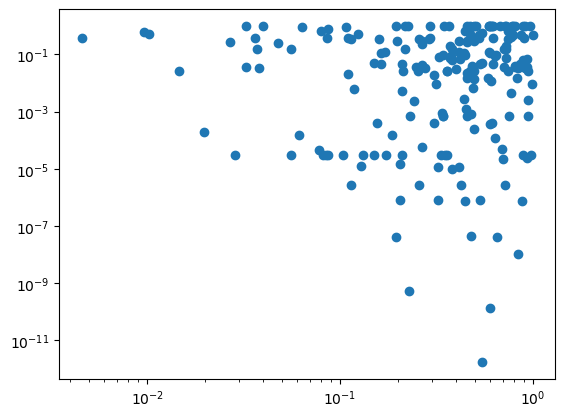

In [10]:
fig, ax = plt.subplots()
ax.scatter(x='pval', y='iMAT pval', data=metprof)
ax.set_xscale('log')
ax.set_yscale('log')

In [11]:
%connect_info

{
  "shell_port": 58784,
  "iopub_port": 58785,
  "stdin_port": 58786,
  "control_port": 58788,
  "hb_port": 58787,
  "ip": "127.0.0.1",
  "key": "cca4a2dd-1342c4edc2fdee24b0c9877d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e1d387b8-1875-4b5f-af9b-48ec736de193.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
